# Kaggle's Pneumonia Detection Using Transfer Learning

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator

In [2]:
baseDir = './chest_xray'
trainDir = os.path.join(baseDir, 'train')
testDir = os.path.join(baseDir, 'test')
valDir = os.path.join(baseDir, 'val')

In [3]:
train_size = 5216 #3875+1341
test_size = 624 #234+390
valid_size = 8+8
batch_size = 20

## VGG16 Model

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(150,150,3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True;
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 10


In [17]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        trainDir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        valDir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [23]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator)

Epoch 1/20
100/100 [==============================] - 130s 1s/step - loss: 0.0063 - acc: 0.9975 - val_loss: 0.3145 - val_acc: 0.8750
Epoch 2/20
100/100 [==============================] - 125s 1s/step - loss: 0.0061 - acc: 0.9975 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 3/20
100/100 [==============================] - 131s 1s/step - loss: 0.0042 - acc: 0.9990 - val_loss: 1.0966 - val_acc: 0.8125
Epoch 4/20
100/100 [==============================] - 123s 1s/step - loss: 0.0050 - acc: 0.9975 - val_loss: 0.0133 - val_acc: 1.0000
Epoch 5/20
100/100 [==============================] - 129s 1s/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.1244 - val_acc: 0.9375
Epoch 6/20
100/100 [==============================] - 135s 1s/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0736 - val_acc: 0.9375
Epoch 7/20
100/100 [==============================] - 148s 1s/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.1624 - val_acc: 0.9375
Epoch 8/20
100/100 [==============================] - 149s 1s/step - 

In [24]:
model.save("VGG16_RMSProp1e-5.h5")

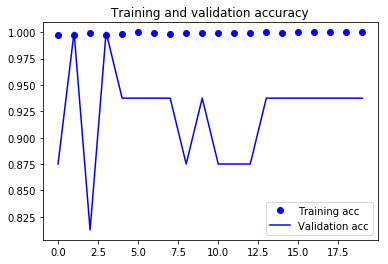

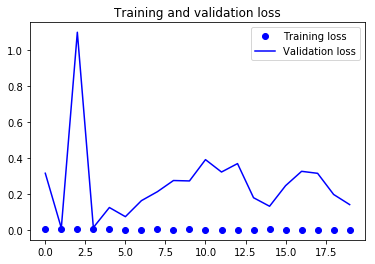

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

validation data compared to train/test is way too off balance, which is why the validation accuracy and loss fluctuates.

## ResNet50 Model

In [27]:
from tensorflow.keras.applications.resnet import ResNet50

res_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(150,150,3))

In [28]:
res_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(res_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator)

model.save("ResNet50_SGD1e-5.h5")

Epoch 1/20
100/100 [==============================] - 253s 3s/step - loss: 0.7742 - acc: 0.6095 - val_loss: 2.7505 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 252s 3s/step - loss: 0.5457 - acc: 0.7305 - val_loss: 8.6637 - val_acc: 0.5000
Epoch 3/20
100/100 [==============================] - 262s 3s/step - loss: 0.4415 - acc: 0.7891 - val_loss: 15.4498 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 279s 3s/step - loss: 0.3818 - acc: 0.8362 - val_loss: 17.5476 - val_acc: 0.5000
Epoch 5/20
100/100 [==============================] - 317s 3s/step - loss: 0.3310 - acc: 0.8575 - val_loss: 13.4167 - val_acc: 0.5000
Epoch 6/20
100/100 [==============================] - 316s 3s/step - loss: 0.2993 - acc: 0.8770 - val_loss: 8.0900 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 300s 3s/step - loss: 0.2794 - acc: 0.8845 - val_loss: 2.6142 - val_acc: 0.5000
Epoch 8/20
100/100 [==============================] - 261s 3s/step

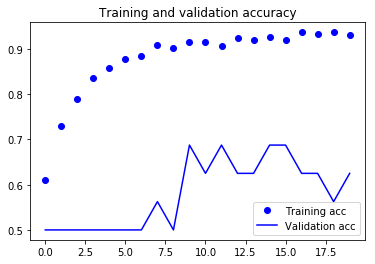

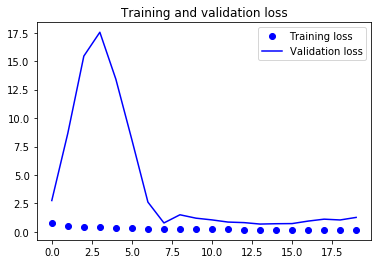

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- From both models, it can be seen that the dataset needs to be rebalanced.
- Will use sklearn's train-test-split to rebalance the dataset and see how this would improve the accuracy.